# Pipeline TE

In [3]:
import os
os.chdir('/home/clemens/armed_conflict_avalanche/')

from workspace.utils import *
from voronoi_globe.interface import load_voronoi
from arcolanche.pipeline import *
from arcolanche.transfer_entropy_func import *

import statsmodels.api as sm

from utils_CB import get_coarsegrained, plot_cells, get_ids_from_centroid

from math import factorial

from shapely.geometry import LineString
from keplergl import KeplerGl


# Data, subset

In [4]:
conflict_type = "battles"
mesoscale = (32,453,3) #(dt, dx, gridix)
coarse = (32, 80, 3)

dt, dx, gridix = mesoscale

#data
load_pickle(f"avalanches/{conflict_type}/gridix_{gridix}/te/conflict_ev_{str(dt)}_{str(dx)}.p")
count_ts = get_coarsegrained(conflict_type, scale = mesoscale, binary=True)
polygons = load_voronoi(dx, gridix) #dx=57/b=528km, gridix=3

Subset of dataset is used: Construct.py subsets neighborhood of degree three around central node 7311. Quite messy way to do it but yeah.

Cells in subset: 35
tuples in subset of size 3: 1190.0
dt: 32, dx: 453 gridix: 3


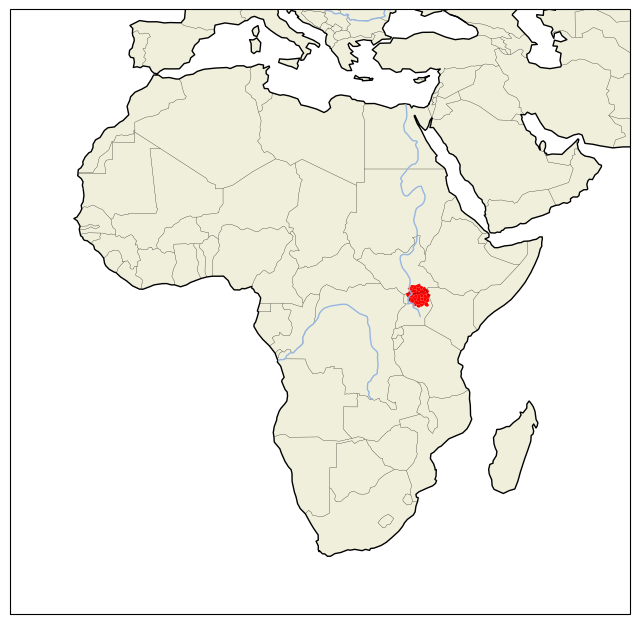

In [3]:
size = 3
degree = 2
centroid = 7311 #counts: 218 
cell_ids = get_ids_from_centroid(polygons, size= size, centroid = 7311)
print("Cells in subset:", len(cell_ids))


def binomial(n, k):
#number of unique k sets in n
    return (factorial(n)/(factorial(k)*factorial(n-k)))

print(f"tuples in subset of size {size}:", binomial(len(cell_ids), 2)*2)

#Plot subset (used in pipeline)
plot_cells(cell_ids, mesoscale, "battles", verbose=False)

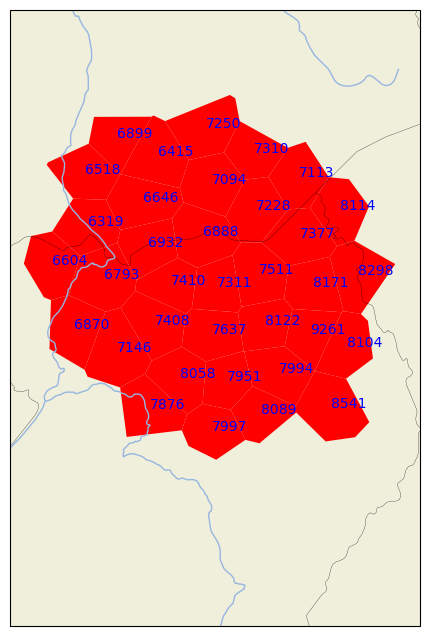

In [4]:
# Zoom in
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

# Specify polygon and event here
for i, x in enumerate(cell_ids):
    poly = polygons.loc[[x]]
    poly.plot(ax=ax, color="red")
    
    # Get the centroid of the polygon
    centroid = poly.geometry.centroid.iloc[0]
    # Place the index of the polygon as text on the map
    ax.text(centroid.x, centroid.y, str(x), color='blue', transform=ccrs.Geodetic())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.LAND)   
ax.add_feature(cfeature.RIVERS)

# Zoom in on Kenya, South Sudan, and Uganda

ax.set_extent([31, 35, 0, 6], crs=ccrs.PlateCarree())

plt.show()

# Compare avalanches

In [37]:
dt = 64
dx = 320
degree = 5

def open_avalanche(conflict_type, gridix, dt, dx, degree):
    path = f"Results/avalanches/{conflict_type}/gridix_{gridix}/d{degree}_ava_{str(dt)}_{str(dx)}.p"
    
    with open(path, 'rb') as file:
        data = pickle.load(file)
    return data


avas = [open_avalanche(conflict_type, gridix, dt, dx, degree=d) for d in range(1, degree+1)]
sets = [set(map(tuple, ava['ava_event'])) for ava in avas]


In [40]:
# Calculate the size of each set
sizes = [len(s) for s in sets]

# Calculate pairwise intersections
intersections = [[len(sets[i].intersection(sets[j])) for j in range(len(sets))] for i in range(len(sets))]

# Calculate pairwise Jaccard indices
jaccard_indices = [
    [
        intersections[i][j] / len(sets[i].union(sets[j])) if i != j else 1.0
        for j in range(len(sets))
    ]
    for i in range(len(sets))
]

# Initialize the data for the table
data = {
    "Set": [f"Set {i+1}" for i in range(len(sets))],
    "Size": sizes
}

# Add intersection columns
for i in range(len(sets)):
    data[f"Intersect with Set {i+1}"] = intersections[i]

# Add Jaccard index columns
for i in range(len(sets)):
    data[f"Jaccard with Set {i+1}"] = jaccard_indices[i]

# Create a DataFrame
df = pd.DataFrame(data)
df

,Set,Size,Intersect with Set 1,Intersect with Set 2,Intersect with Set 3,Intersect with Set 4,Intersect with Set 5,Jaccard with Set 1,Jaccard with Set 2,Jaccard with Set 3,Jaccard with Set 4,Jaccard with Set 5
0,Set 1,7998,7998,4490,3212,2514,2015,1.000000,0.512265,0.374315,0.299001,0.242596
1,Set 2,5257,4490,5257,3244,2460,1989,0.512265,1.000000,0.558540,0.429995,0.355750
2,Set 3,3795,3212,3244,3795,2417,2001,0.374315,0.558540,1.000000,0.561832,0.486034
3,Set 4,2924,2514,2460,2417,2924,1986,0.299001,0.429995,0.561832,1.000000,0.609016
4,Set 5,2323,2015,1989,2001,1986,2323,0.242596,0.355750,0.486034,0.609016,1.000000
